In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

sns.set(style="whitegrid")

In [6]:
raw = pd.read_csv("dataset/compas-scores-two-years-violent.csv")
print(f"Total rows: {len(raw)}")

Total rows: 4743


In [9]:
df = raw.loc[:, [
    'age','c_charge_degree','race','age_cat','v_score_text','sex',
    'priors_count','days_b_screening_arrest','v_decile_score',
    'is_recid','two_year_recid'
]].copy()

In [10]:
df = df[
    df['days_b_screening_arrest'].between(-30,30) &
    (df['is_recid'] != -1) &
    (df['c_charge_degree'] != 'O') &
    (df['v_score_text'] != 'N/A')
]
print(f"Rows after filtering: {len(df)}")

Rows after filtering: 4020


In [12]:
print("Age categories:\n", df['age_cat'].value_counts(), "\n")
print("Race:\n", df['race'].value_counts(), "\n")
print("Violent score text:\n", df['v_score_text'].value_counts(), "\n")
recid_rate = df['two_year_recid'].mean() * 100
print(f"Two‐year recidivism rate: {recid_rate:.1f}%")

Age categories:
 age_cat
25 - 45            2300
Greater than 45     954
Less than 25        766
Name: count, dtype: int64 

Race:
 race
African-American    1918
Caucasian           1459
Hispanic             355
Other                255
Asian                 26
Native American        7
Name: count, dtype: int64 

Violent score text:
 v_score_text
Low       2913
Medium     828
High       279
Name: count, dtype: int64 

Two‐year recidivism rate: 16.2%


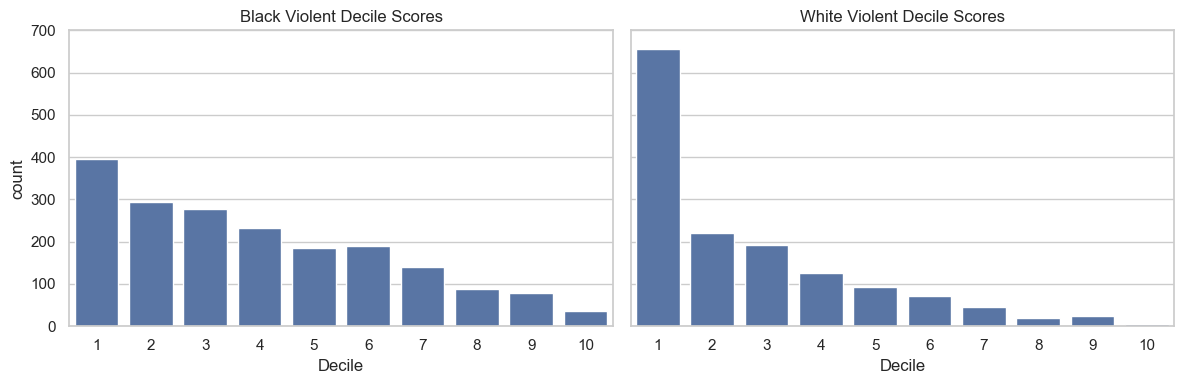

In [13]:
fig, axes = plt.subplots(1,2,figsize=(12,4), sharey=True)
order = sorted(df['v_decile_score'].unique())

sns.countplot(x='v_decile_score',
              data=df[df['race']=="African-American"],
              order=order, ax=axes[0])
axes[0].set(title="Black Violent Decile Scores", xlabel="Decile", ylim=(0,700))

sns.countplot(x='v_decile_score',
              data=df[df['race']=="Caucasian"],
              order=order, ax=axes[1])
axes[1].set(title="White Violent Decile Scores", xlabel="Decile", ylim=(0,700))

plt.tight_layout()
plt.show()

In [25]:
df['high_vscore'] = (df['v_score_text'] != 'Low').astype(int)

# Caucasian is the reference level
df['race_cat'] = pd.Categorical(
    df['race'],
    categories=[
        'Caucasian',
        'African-American',
        'Asian',
        'Hispanic',
        'Native American',
        'Other'
    ],
    ordered=False
)

In [30]:
model = smf.logit(
    formula=(
        "high_vscore ~ "
        "C(sex) + "
        "C(age_cat) + "
        "C(race_cat, Treatment(reference='Caucasian')) + "
        "priors_count + "
        "C(c_charge_degree) + "
        "two_year_recid"
    ),
    data=df
).fit(disp=False)

print(model.summary())

                           Logit Regression Results                           
Dep. Variable:            high_vscore   No. Observations:                 4020
Model:                          Logit   Df Residuals:                     4008
Method:                           MLE   Df Model:                           11
Date:                Tue, 13 May 2025   Pseudo R-squ.:                  0.3662
Time:                        20:42:34   Log-Likelihood:                -1499.4
converged:                       True   LL-Null:                       -2365.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            -2.9716      0.156    -19.050  

In [31]:
params = model.params
b0        = params['Intercept']
b_black   = params['C(race_cat, Treatment(reference=\'Caucasian\'))[T.African-American]']
b_male    = params['C(sex)[T.Male]']
b_under25 = params['C(age_cat)[T.Less than 25]']

In [34]:
p0 = np.exp(b0) / (1 + np.exp(b0))
print(f"Baseline P(high violent score): {p0:.3f}")

def adj_ratio(beta):
    num = np.exp(beta)
    return num / (1 - p0 + p0 * num)

print(f"African-American vs. White ratio: {adj_ratio(b_black):.3f}")
print(f"Male vs. Female ratio:           {adj_ratio(b_male):.3f}")
print(f"<25 vs. 25–45 ratio:             {adj_ratio(b_under25):.3f}")


Baseline P(high violent score): 0.049
African-American vs. White ratio: 1.849
Male vs. Female ratio:           1.970
<25 vs. 25–45 ratio:             11.154


### Updated Conclusions (Violent Recidivism)

- **African-American vs. White**: Black defendants are **1.85×** as likely as White defendants to receive a High violent-risk score (≈ 84.9 % higher probability).  
- **Male vs. Female**: Male defendants are **1.97×** as likely as female defendants to be labeled High violent risk (≈ 97.0 % higher probability).  
- **Under 25 vs. 25–45**: Defendants under 25 are **11.15×** as likely as 25–45-year-olds to get a High violent-risk score (≈ 1 015 % higher probability).  